In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle

from utils import *

In [2]:
val_dates = ['180328','180329']
test_dates = ['180330','180331']

train_loader, val_loader, test_loader = create_dataloaders(val_dates=val_dates, test_dates=test_dates, batch_size=128, version='_Goose_1st_1', upsample=True)

In [3]:
len(train_loader), len(val_loader), len(test_loader)

(258, 22, 51)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = F.relu(self.linear1(x))
        outputs = self.linear2(x1)
        return outputs

In [5]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    if val_losses:
        if val_loss < min(val_losses):
            best_epoch = epoch
            print(epoch)
            path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
            torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    
    if train_loss < tol:
        break

Train loss for epoch 0: 5.637181758880615
Val loss for epoch 0: 1.0339089632034302
Train loss for epoch 1: 1.528361439704895
Val loss for epoch 1: 0.634041965007782
1
Train loss for epoch 2: 0.38548359274864197
Val loss for epoch 2: 0.4849734306335449
2
Train loss for epoch 3: 0.18208247423171997
Val loss for epoch 3: 0.4101341664791107
3
Train loss for epoch 4: 0.13340263068675995
Val loss for epoch 4: 0.3668285310268402
4
Train loss for epoch 5: 0.10207942128181458
Val loss for epoch 5: 0.34699487686157227
5
Train loss for epoch 6: 0.11003502458333969
Val loss for epoch 6: 0.45482730865478516
Train loss for epoch 7: 0.08611515164375305
Val loss for epoch 7: 0.33059871196746826
7
Train loss for epoch 8: 0.08065655827522278
Val loss for epoch 8: 0.595654308795929
Train loss for epoch 9: 0.08533122390508652
Val loss for epoch 9: 0.8833327889442444
Train loss for epoch 10: 0.09560886770486832
Val loss for epoch 10: 1.0663920640945435
Train loss for epoch 11: 0.08987785130739212
Val loss 

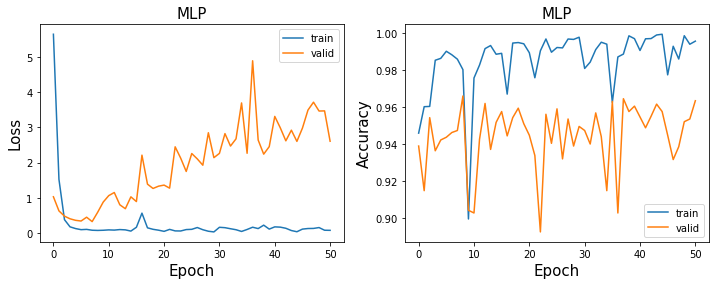

In [8]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type)

In [10]:
model = MLP().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

In [11]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.48869988322257996 accuracy:0.936


In [12]:
path_wrong = '/mnt/pesaranlab/People/Capstone_students/Yue/wrong_pred'
pickle.dump(cases_wrong_0, open('{}/{}_CH{}_LOSS{}_REG{}{}.pt'.format(path_wrong, model_type, CH, loss_type, reg_type, alpha), 'wb'))

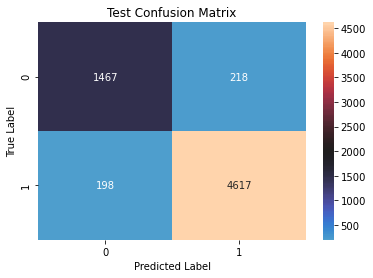

In [13]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

date:180331, rec:001, time:001, label:1.0
Original data 62 CH


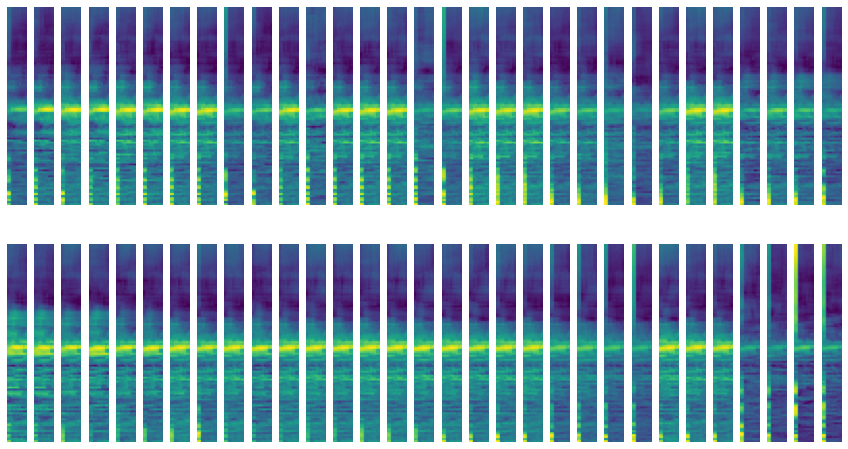

In [14]:
idx = 0
print('date:{}, rec:{}, time:{}, label:{}'.format(cases_wrong_0[0][0], cases_wrong_0[0][1], cases_wrong_0[0][1], cases_wrong_0[0][3]))
print('Original data 62 CH')
plt.figure(figsize=(15,8))
for i in range(62):
    weights_sub = cases_wrong_0[0][-1][i]
    plt.subplot(2,31,i+1)
    plt.axis('off')
    plt.imshow(weights_sub)
plt.show()